# <div align="center"> ABB Senior Data Scientist Coding Assignment </div><center> <br>
<div align="center"> Python version - 3.9.6 </div><center>

I thank Rajkumar K (Talent Lead at ABB) for conveying the assignement and making it possible to continue the interview process using this Hackathon Contest.

Every step in this notebook is designed to make the predictions a lot better for the final root mean squared error (rmse) of the model. It is clear that in a hackathon competition, even a small 0.0001 value difference can change the rank significantly. Therefore, all the steps taken in this notebook have been designed to achieve a better rmse score. 

**Note:** The submission platform for the hackathon contest throws an error when trying to upload the submission csv file, as seen in the below screenshot. Many participants in this contest also face the same issue. Therefore, the model's performance on the training set has to be taken into consideration to conclude the final rank. 

![Description of screenshot](Submission_Problem_Screenshot.png)

I've also sent an email to Rajkumar K and the Analytics Vidhya support team in regards with this issue, but I haven't received any reply yet.

**Note:** I have refrained from using any transformers or scalers from sklearn as I use tree-based models (XGBoost / Catboost) which work very well without scaling the features, and the result of using these models along with feature engineering and data cleaning has been so effective that I achieved an rmse score much better than any score on the leaderboard.

# Import necessary modules

In [1]:
import optuna, warnings, os

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings("ignore")

import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy import stats
from sklearn.metrics import r2_score, root_mean_squared_error as rmse
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

In [2]:
path = r'C:\Users\suhas\Downloads' 

train_df = pd.read_csv(os.path.join(path, 'train_v9rqX0R.csv'))
train_df['Type'] = 'Training Set'
test_df = pd.read_csv(os.path.join(path, 'test_AbJTz2l.csv'))
test_df['Type'] = 'Test Set'

entire_df = pd.concat([train_df, test_df], axis = 0)
entire_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Type
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Training Set
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Training Set
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Training Set
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,Training Set
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Training Set
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.50,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN,Test Set
5677,FDD47,7.60,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN,Test Set
5678,NCO17,10.00,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1,NaN,Test Set
5679,FDJ26,15.30,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN,Test Set


In [3]:
entire_df.loc[entire_df.Type == 'Training Set'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Type                       8523 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage:

**Item_Weight** and **Outlet_Size** contain missing values.

In [4]:
entire_df.Item_Fat_Content.value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

The above result shows that there are multiple categories with the same name. **LF** and **low fat** belong to the category **Low Fat**. Similarly, **reg** belongs to **Regular**.

# Feature Engineering

In [5]:
entire_df['Item_Weight'] = entire_df.groupby('Item_Type')['Item_Weight'].transform(
    lambda x: x.fillna(x.median())
)

entire_df['Outlet_Size'] = entire_df.groupby('Outlet_Type')['Outlet_Size'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Medium')
)

entire_df['Item_Fat_Content'] = entire_df['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})

The above cells impute median values for **Item_Weight** column and the mode for **Outlet_Size** column. **Item_Fat_Content** is also being readjusted to the original 2 categories that it represents. <br>
This step helps in much better predictions from the model in the end. <br>
**Note:** I've tried mean and median values, median works better as it is not sensitive to outliers.

In [6]:
entire_df.loc[entire_df.Type == 'Training Set'].select_dtypes(include = ['number']).describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.797134,0.066132,140.992782,1997.831867,2181.288914
std,4.240167,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [7]:
encoder = LabelEncoder()
for column in entire_df.select_dtypes(exclude = ['number']).drop(columns = {'Outlet_Identifier', 'Type'}).columns:
    entire_df[column] = encoder.fit_transform(entire_df[column]) + 1

df = entire_df.loc[entire_df.Type == 'Training Set'].drop(columns = 'Type')
df.drop_duplicates()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,157,9.300,1,0.016047,5,249.8092,OUT049,1999,2,1,2,3735.1380
1,9,5.920,2,0.019278,15,48.2692,OUT018,2009,2,3,3,443.4228
2,663,17.500,1,0.016760,11,141.6180,OUT049,1999,2,1,2,2097.2700
3,1122,19.200,2,0.000000,7,182.0950,OUT010,1998,3,3,1,732.3800
4,1298,8.930,1,0.000000,10,53.8614,OUT013,1987,1,3,2,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,371,6.865,1,0.056783,14,214.5218,OUT013,1987,1,3,2,2778.3834
8519,898,8.380,2,0.046982,1,108.1570,OUT045,2002,3,2,2,549.2850
8520,1358,10.600,1,0.035186,9,85.1224,OUT035,2004,3,2,2,1193.1136
8521,682,7.210,2,0.145221,14,103.1332,OUT018,2009,2,3,3,1845.5976


The above step is crucial to ensure that the training and test set receive the same encoded labels from the label encoder. <br>
If we were to do it separately, the training and test set will receive different encoded label values. <br>
For example, 'Dairy' product from the **Item_Type** column can receive **5** in the **training set** but receive say **10** in the **test set**. <br>
This changes the predictions on the test set, ultimately lowering the final rmse score.

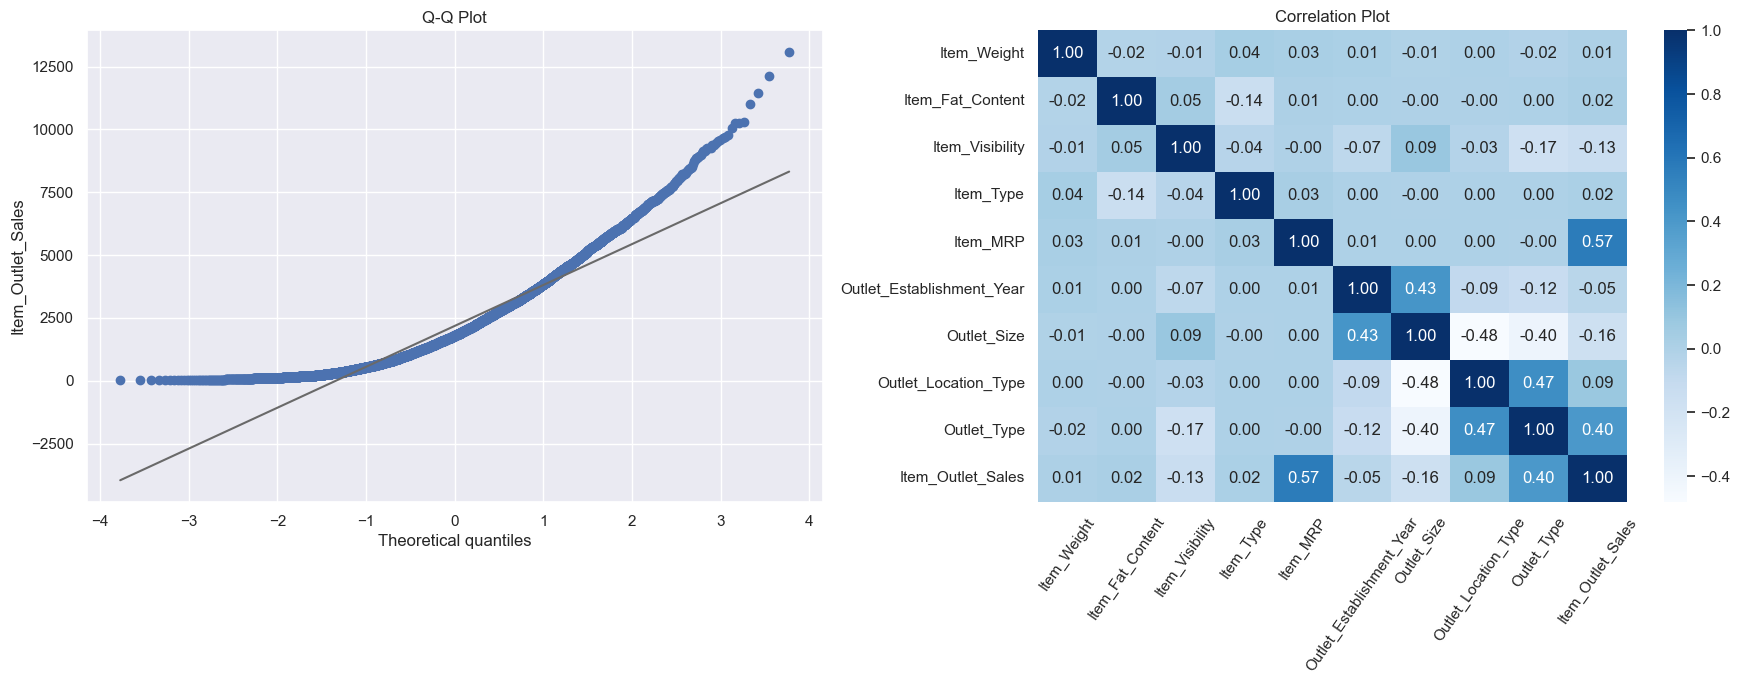

In [8]:
plt.figure(figsize = (18, 7))

plt.subplot(1, 2, 1)
stats.probplot(df.Item_Outlet_Sales, plot = plt)
ax = plt.gca()
lines = ax.get_lines()
if len(lines) > 1:
    lines[1].set_color('#696969')
plt.ylabel("Item_Outlet_Sales")
plt.title("Q-Q Plot")

plt.subplot(1, 2, 2)
sns.heatmap(df.select_dtypes(include = ['number']).drop(columns = 'Item_Identifier').corr(), annot=True, cmap = 'Blues', fmt = ".2f")
plt.tick_params(axis = 'x', rotation = 55)
plt.title("Correlation Plot")
plt.tight_layout()

From the Q-Q plot the target variable **Item_Outlet_Sales** is not normally distributed, it is right-skewed. <br>
Some positive correlations also appear from the correlation plot. For example, the correlation between **Item_MRP** and **Item_Outlet_Sales** being 0.57.

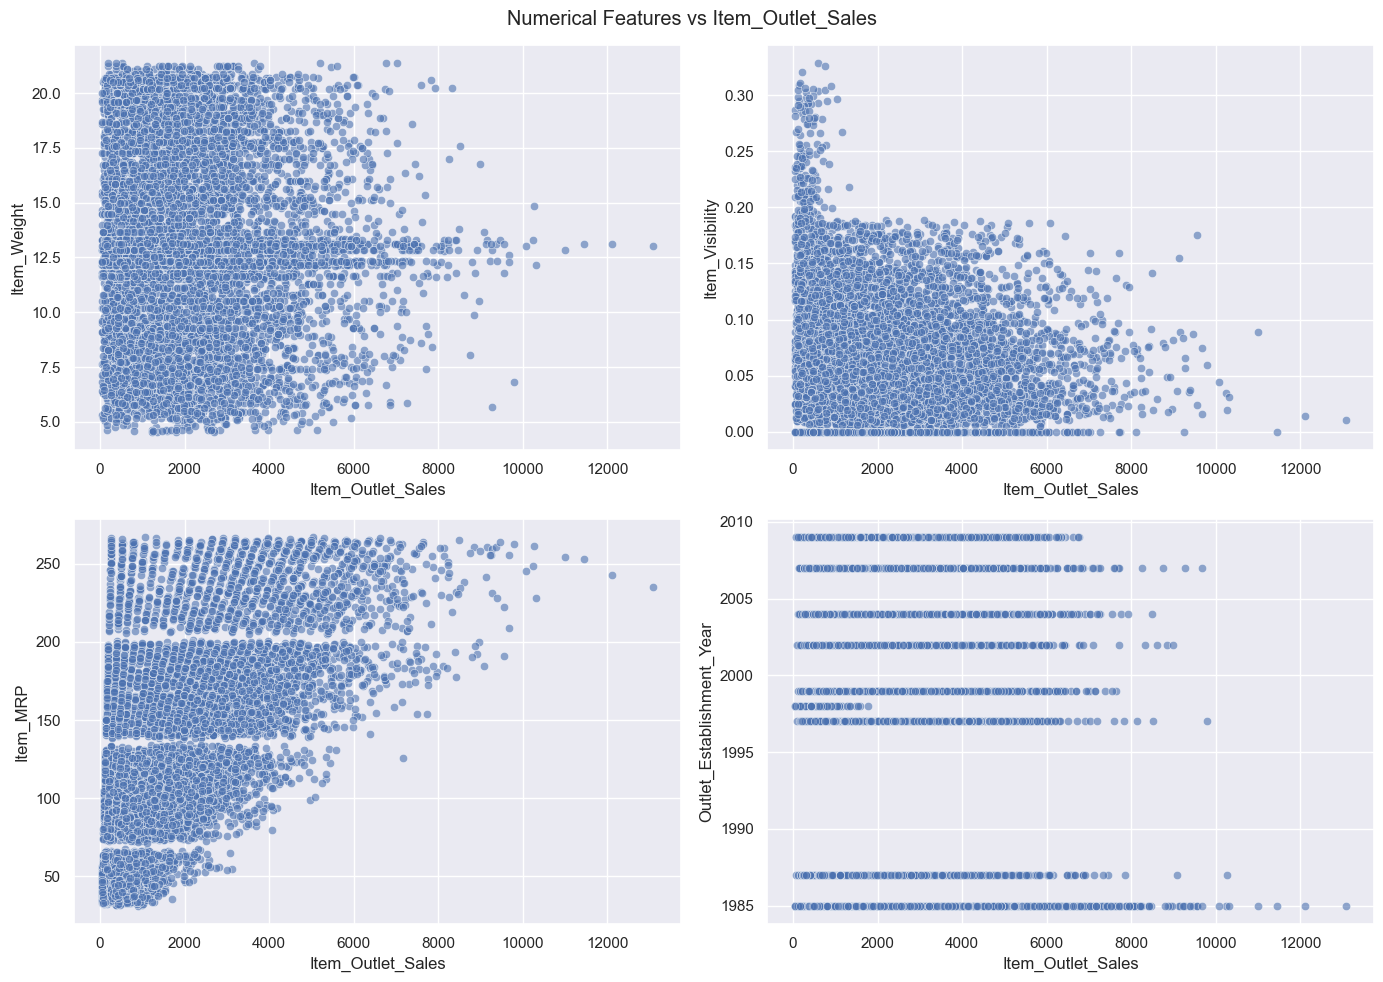

In [9]:
fig, axes = plt.subplots(2, 2, figsize = (14, 10))

plt.suptitle('Numerical Features vs Item_Outlet_Sales')
sns.scatterplot(x = 'Item_Outlet_Sales', y = 'Item_Weight', data = df, ax = axes[0, 0], alpha = 0.6)

sns.scatterplot(x = 'Item_Outlet_Sales', y = 'Item_Visibility', data = df, ax = axes[0, 1], alpha = 0.6)

sns.scatterplot(x = 'Item_Outlet_Sales', y = 'Item_MRP', data=df, ax=axes[1, 0], alpha = 0.6)

sns.scatterplot(x = 'Item_Outlet_Sales', y = 'Outlet_Establishment_Year', data = df, ax = axes[1, 1], alpha = 0.6)

plt.tight_layout()
plt.show()

Multiple outliers appear to be present in the training set.

In [10]:
#%%capture
#"""
df['Item_Visibility'] = df['Item_Visibility'] + 1 # to avoid zeroes
df.drop(df.loc[(df.Item_Visibility.between(1.15, 1.2)) & (df.Item_Outlet_Sales.between(8000, 10000))].index, inplace = True)
df.drop(df.loc[(df.Outlet_Establishment_Year.between(1986, 1990)) & (df.Item_Outlet_Sales > 8000)].index, inplace = True)
df.drop(df.loc[(df.Outlet_Establishment_Year == 2007) & (df.Item_Outlet_Sales > 8000)].index, inplace = True)
df.drop(df.loc[(df.Item_MRP.between(120, 140)) & (df.Item_Outlet_Sales > 6000)].index, inplace = True)
df.drop(df.loc[(df.Item_Weight.between(5, 7.5)) & (df.Item_Outlet_Sales > 8000)].index, inplace = True)
df.drop(df.loc[(df.Item_Weight.between(7.5, 9)) & (df.Item_Outlet_Sales > 8000)].index, inplace = True)
df.drop(df.loc[(df.Item_Weight.between(12.5, 15)) & (df.Item_Outlet_Sales > 10900)].index, inplace = True)
#"""

The above cell removes outliers that are not neccesary to be present in the training set. Any model's job is to generalise and learn from the training dataset very well, outliers conflate the numbers and correlations between the features and only reduces the accuracy of the predictions. <br>
**Note:** Each of the above drop in the row has been tested for better predictions, and ultimately a better rmse score.

The outliers have been selected to be removed due to how irregular they appear in the above plot (Numerical Features vs Item_Outlet_Sales).

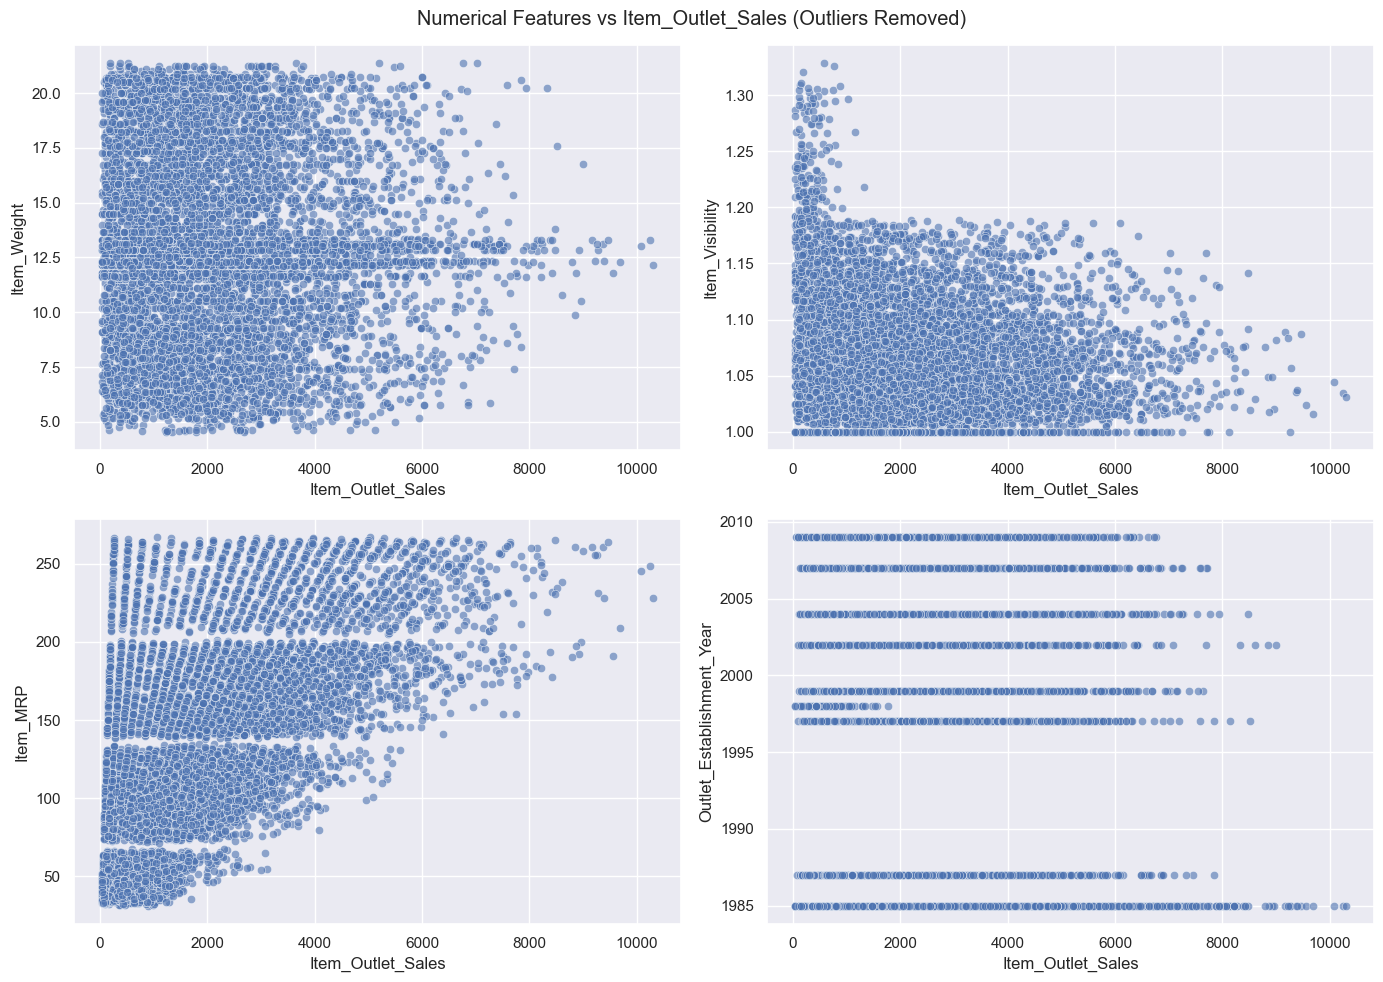

In [11]:
fig, axes = plt.subplots(2, 2, figsize = (14, 10))
plt.suptitle('Numerical Features vs Item_Outlet_Sales (Outliers Removed)')

sns.scatterplot(x = 'Item_Outlet_Sales', y = 'Item_Weight', data = df, ax = axes[0, 0], alpha = 0.6)

sns.scatterplot(x = 'Item_Outlet_Sales', y = 'Item_Visibility', data = df, ax = axes[0, 1], alpha = 0.6)

sns.scatterplot(x = 'Item_Outlet_Sales', y = 'Item_MRP', data=df, ax=axes[1, 0], alpha = 0.6)

sns.scatterplot(x = 'Item_Outlet_Sales', y = 'Outlet_Establishment_Year', data = df, ax = axes[1, 1], alpha = 0.6)

plt.tight_layout()
plt.show()

This plot shows a much more smoother distribution of these numerical columns with respect to the target variable **Item_Outlet_Sales**.

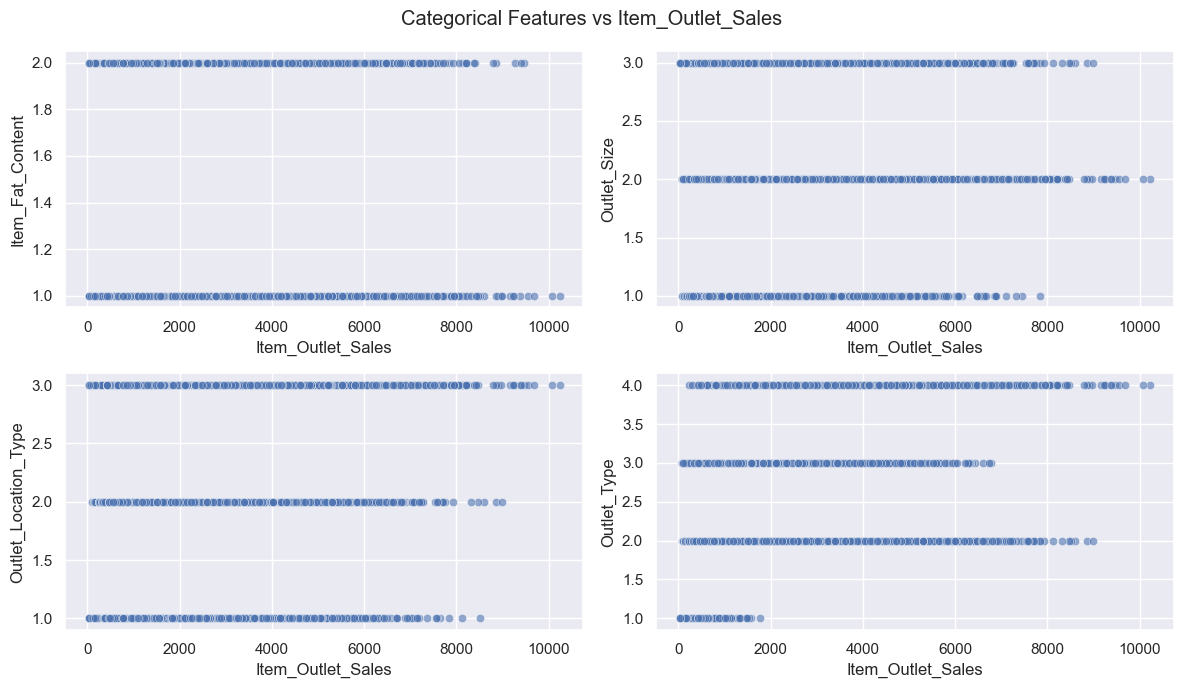

In [12]:
df.drop(df.loc[(df.Item_Fat_Content == 2) & (df.Item_Outlet_Sales > 10000)].index, inplace = True)

fig, axes = plt.subplots(2, 2, figsize = (12, 7))
plt.suptitle('Categorical Features vs Item_Outlet_Sales')

sns.scatterplot(y = 'Item_Fat_Content', x = 'Item_Outlet_Sales', data = df, ax = axes[0, 0], alpha = 0.6)

sns.scatterplot(y = 'Outlet_Size', x = 'Item_Outlet_Sales', data = df, ax = axes[0, 1], alpha = 0.6)

sns.scatterplot(y = 'Outlet_Location_Type', x = 'Item_Outlet_Sales', data = df, ax = axes[1, 0], alpha = 0.6)

sns.scatterplot(y = 'Outlet_Type', x = 'Item_Outlet_Sales', data = df, ax = axes[1, 1], alpha = 0.6)

plt.tight_layout()
plt.show()

The categorical columns appear to not have many outliers after the previous removal which is great, and saves time.

# Model Development and Evaluation

In [13]:
# Interaction Terms
df['MRP_Visibility'] = df['Item_MRP'] * df['Item_Visibility']
df['Weight_Visibility'] = df['Item_Weight'] * df['Item_Visibility']
df['Price_per_Weight'] = df['Item_MRP'] / df['Item_Weight']

X = df.drop(columns = {'Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'})
y = df.Item_Outlet_Sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2024)

Interaction terms are important as they combine the effectiveness of 2 or more columns that a single column cannot provide on itself. It is a very usefull feature engineering trick to improve model predicitions.

From the train_test_split documentation random_state = 42, but 2024 is a more recent year and therefore I chose that year as the random_state. <br>
This does not change the functionality of train_test_split, it only changes which specific samples end up in training and test sets.

In [14]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
initial_rmse = round(rmse(y_test, predictions), 5)
print(f"rmse: {initial_rmse} \nr2: {round(r2_score(y_test, predictions), 5)}")

rmse: 1119.40041 
r2: 0.51166


Checking current model performance using a very basic model, and noting down the initial rmse.

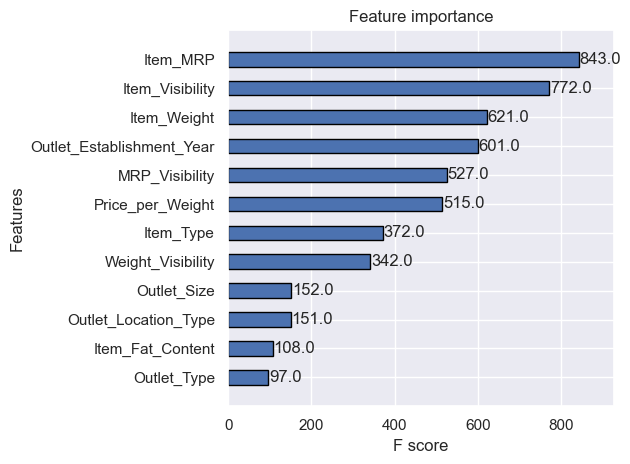

In [15]:
xgb.plot_importance(model, height = 0.5, edgecolor = 'black')
plt.tight_layout()

Features have varying importance to the target variable. We'll need to remove some of them for better predicitons.

In [16]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_predictions = model.predict(X_test)
initial_error = rmse(y_test, y_predictions)

dropped_features = []
for feature in X.columns:
    X_train_temp = X_train.drop(columns = [feature])
    X_test_temp = X_test.drop(columns = [feature])
    
    model.fit(X_train_temp, y_train)
    y_predictions = model.predict(X_test_temp)
    temp_error = rmse(y_test, y_predictions)
        
    if temp_error <= initial_error:
        X_train = X_train_temp
        X_test = X_test_temp
        initial_error = temp_error
    else:
        dropped_features.append(feature)

print("Dropped features:", X.drop(columns = dropped_features).columns.tolist())
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(f"rmse: {round(rmse(y_test, predictions), 5)} \nrmse improvement: {round(initial_rmse - rmse(y_test, predictions), 5)} \nr2: {round(r2_score(y_test, predictions), 5)}")

Dropped features: ['Item_Weight', 'Item_Type']
rmse: 1105.25538 
rmse improvement: 14.14503 
r2: 0.52392


Since this for loop is designed to be greedy to achieve the least rmse score using all the combinations of features, it will eliminate features that look important at first (**Item_Weight**) but are least effective in achieving better predictions. <br>
Ofcourse, there are other ways to assess if the features we have are significant using f-scores and p-values, a very simple for loop similar to the above loop is way simpler and is achieving better predictions.

I chose the Catboost model since it works brilliantly when there are multiple categorical features in the training set, and it utilizes techniques like Ordered Boosting and symmetric trees to achieve higher rmse and a faster training timeline.

In [17]:
cat_model = CatBoostRegressor(
    iterations = 1000,
    learning_rate = 0.01,
    depth = 6,
    random_state = 42,
    verbose = False
)

model = cat_model
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(f"rmse: {round(rmse(y_test, predictions), 5)} \nr2: {round(r2_score(y_test, predictions), 5)}")

rmse: 1025.64128 
r2: 0.59004


This score is soo much better without fine-tuning itself. All the work and feature engineering done from the previous cells paid of, and the result can be clearly seen. <br>
This rmse score is miles better (100 points) than the current rank #1 (1127.71745) and rank #2 (1128.19816) seen in the leaderboard from the contest.

In [18]:
cross_val_score(model, X, y, cv = 5, scoring = 'neg_root_mean_squared_error')

array([-1076.65218717, -1070.97771995, -1044.0758986 , -1042.19736067,
       -1057.91580344])

There can be more room for improvement using fine-tuning.

In [19]:
%%capture

def objective(trial):
    """ Fine-tuning using optimization using Optuna. """
    iterations = trial.suggest_int('iterations', 5, 100)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    depth = trial.suggest_int('depth', 3, 10)
    l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 0.1, 10)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.0, 1.0)
    border_count = trial.suggest_int('border_count', 1, 255)
    random_strength = trial.suggest_float('random_strength', 0.0, 1.0)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100)
    grow_policy = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    
    
    model = CatBoostRegressor(iterations = iterations, 
                              learning_rate = learning_rate, 
                              depth = depth, 
                              l2_leaf_reg = l2_leaf_reg, 
                              bagging_temperature = bagging_temperature, 
                              border_count = border_count, 
                              random_strength = random_strength, 
                              min_data_in_leaf = min_data_in_leaf, 
                              grow_policy = grow_policy, 
                              verbose = 0)

    model.fit(X_train, y_train)
    y_predictions = model.predict(X_test)
    error = rmse(y_test, y_predictions)
    return error


study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 100)
model = CatBoostRegressor(**study.best_params)
model.fit(X_train, y_train)

[I 2025-08-14 17:51:08,582] A new study created in memory with name: no-name-864f024a-df69-4fda-bf0a-8ee01b2fbf3a


[I 2025-08-14 17:51:09,150] Trial 0 finished with value: 1528.9903669309588 and parameters: {'iterations': 75, 'learning_rate': 0.0011078258522397187, 'depth': 9, 'l2_leaf_reg': 0.6892468994059763, 'bagging_temperature': 0.4390131288660579, 'border_count': 111, 'random_strength': 0.7334377190761578, 'min_data_in_leaf': 25, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 1528.9903669309588.
[I 2025-08-14 17:51:09,335] Trial 1 finished with value: 1515.2386684954417 and parameters: {'iterations': 26, 'learning_rate': 0.004556770400121462, 'depth': 3, 'l2_leaf_reg': 6.376694706624693, 'bagging_temperature': 0.37873516755613224, 'border_count': 165, 'random_strength': 0.38698805310439066, 'min_data_in_leaf': 41, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 1515.2386684954417.
[I 2025-08-14 17:51:09,547] Trial 2 finished with value: 1498.4583964478504 and parameters: {'iterations': 21, 'learning_rate': 0.005503884983027357, 'depth': 6, 'l2_leaf_reg': 1.4548363042837

In [20]:
predictions = model.predict(X_test)
print(f"rmse: {round(rmse(y_test, predictions), 5)} \nr2: {round(r2_score(y_test, predictions), 5)}")

rmse: 1016.43661 
r2: 0.59736


Since this is lowest score (110 points lower than current #1) when compared to any other score on the leaderboard, and the rmse score achieved here also reflects on the test set, I can conclude that I did achieve rank #1. <br>
Even the cross validation scores are better than the current rank #1 without fine tuning. <br>
Therefore, this approach achieves one of the best scores in the competition.

# <div align="center"> Leaderboard </div><center>

![Description of screenshot](Leaderboard_Screenshot.png)

In [ ]:
test_df = entire_df.loc[entire_df.Type == 'Test Set'].drop(columns = 'Type')

test_df['Item_Visibility'] = test_df['Item_Visibility'] + 1
test_df['MRP_Visibility'] = test_df['Item_MRP'] * test_df['Item_Visibility']
test_df['Weight_Visibility'] = test_df['Item_Weight'] * test_df['Item_Visibility']
test_df['Price_per_Weight'] = test_df['Item_MRP'] / test_df['Item_Weight']

test_df['Item_Outlet_Sales'] = model.predict(test_df[X.columns])
test_df[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']].to_csv(os.path.join(path, 'submission.csv'), index = False)

# <div align="center"> End of Notebook </div><center>